In [1]:
import tensorflow as tf
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing import text, sequence
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.models import Model, Input, Sequential
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, SpatialDropout1D, Activation
from keras.layers import Conv1D, Bidirectional, GlobalMaxPool1D, MaxPooling1D, BatchNormalization
from keras.optimizers import Adam
from keras.utils.vis_utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping
import keras.backend as K

import pandas as pd
import numpy as np
import os
import csv
import matplotlib.pyplot as plt
import seaborn as sns

#text processing 
import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
import re

Using TensorFlow backend.


In [2]:
# ----------Data-------------    
data_dir = "./data/"

train_file = (data_dir + 'train.csv')
test_file = (data_dir + 'test.csv')
test_labels_file = (data_dir + 'test_labels.csv')

print("---Read data---")
#-----------------train file-------------------------
train = pd.read_csv(train_file)

#-----------------test file-------------------------
test_raw = pd.read_csv(test_file)

#------------------test labels-----------------
test_labels = pd.read_csv(test_labels_file)

print("---Complete reading data---")

---Read data---
---Complete reading data---


In [3]:
#Merge the test commeent text with its  lables in one dataframe
test = pd.merge(test_raw, test_labels, on='id', how='inner')

In [4]:
print("Number of rows in TRAIN data =", train.shape[0])
print("Number of columns in TRAIN data =", train.shape[1])
print("\n")
print("-------------------------TRAIN data:-------------------------")
train.head()

Number of rows in TRAIN data = 159571
Number of columns in TRAIN data = 8


-------------------------TRAIN data:-------------------------


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [5]:
print("Number of rows in TEST data =", test.shape[0])
print("Number of columns in TEST data =", test.shape[1])
print("\n")
print("-------------------------TEST data:-------------------------")
test.head()

Number of rows in TEST data = 153164
Number of columns in TEST data = 8


-------------------------TEST data:-------------------------


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...,-1,-1,-1,-1,-1,-1
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...,-1,-1,-1,-1,-1,-1
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap...",-1,-1,-1,-1,-1,-1
3,00017563c3f7919a,":If you have a look back at the source, the in...",-1,-1,-1,-1,-1,-1
4,00017695ad8997eb,I don't anonymously edit articles at all.,-1,-1,-1,-1,-1,-1


In [6]:
#The number of comments for each class

classes = list(train.columns.values)
classes = classes[2:]
print("Classes:\n\n", classes)

numbers = []
for i in classes:
    numbers.append((i, train[i].sum()))
df_statistics = pd.DataFrame(numbers, columns=['Class', 'Number of Comments'])

df_statistics

Classes:

 ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']


,Class,Number of Comments
0,toxic,15294
1,severe_toxic,1595
2,obscene,8449
3,threat,478
4,insult,7877
5,identity_hate,1405


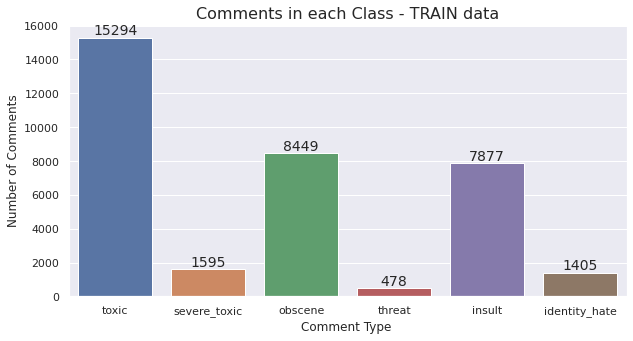

In [7]:
sns.set(font_scale = 1)
plt.figure(figsize=(10,5))

ax= sns.barplot(classes, train.iloc[:,2:].sum().values)

plt.title("Comments in each Class - TRAIN data", fontsize=16)
plt.ylabel('Number of Comments', fontsize=12)
plt.xlabel('Comment Type ', fontsize=12)

#adding the text labels
rects = ax.patches
labels = train.iloc[:,2:].sum().values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom', fontsize=14)

plt.show()

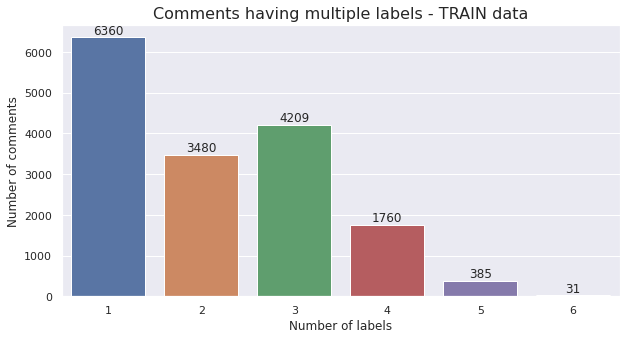

In [8]:
rowSums = train.iloc[:,2:].sum(axis=1)
multiLabel_counts = rowSums.value_counts()
multiLabel_counts = multiLabel_counts.sort_index()
multiLabel_counts = multiLabel_counts.iloc[1:]

sns.set(font_scale = 1)
plt.figure(figsize=(10,5))

ax = sns.barplot(multiLabel_counts.index, multiLabel_counts.values)

plt.title("Comments having multiple labels - TRAIN data", fontsize=16)
plt.ylabel('Number of comments', fontsize=12)
plt.xlabel('Number of labels', fontsize=12)

#adding the text labels
rects = ax.patches
labels = multiLabel_counts.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.show()

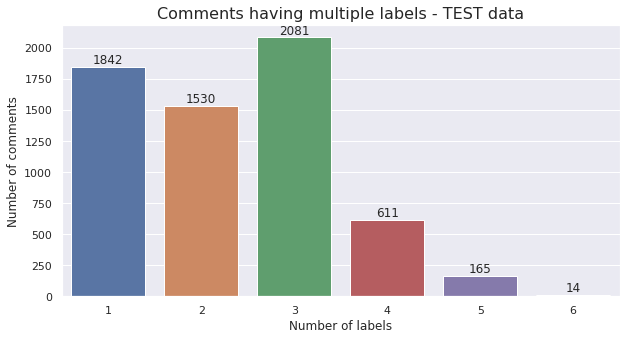

In [11]:
rowSums = test.iloc[:,2:].sum(axis=1)
multiLabel_counts = rowSums.value_counts()
multiLabel_counts = multiLabel_counts.sort_index()
multiLabel_counts = multiLabel_counts.iloc[2:]

sns.set(font_scale = 1)
plt.figure(figsize=(10,5))

ax = sns.barplot(multiLabel_counts.index, multiLabel_counts.values)

plt.title("Comments having multiple labels - TEST data", fontsize=16)
plt.ylabel('Number of comments', fontsize=12)
plt.xlabel('Number of labels', fontsize=12)

#adding the text labels
rects = ax.patches
labels = (multiLabel_counts.values)
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.show()

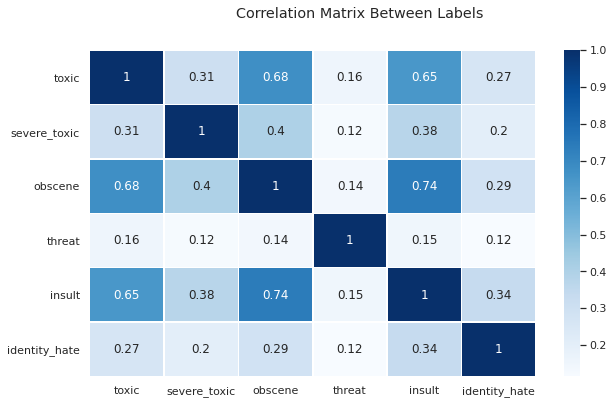

In [13]:
fig, ax = plt.subplots(figsize=(10, 6))
fig.suptitle('Correlation Matrix Between Labels')
sns.heatmap(train.corr(), annot=True, cmap="Blues", linewidths=.5, ax=ax);

In [14]:
def cleanHtml(text):
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', str(text))
    return cleantext

#function to clean the word of any punctuation or special characters
def cleanPunc(text): 
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',text)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',text)
    cleaned = cleaned.strip()
    cleaned = cleaned.replace("\n"," ")
    return cleaned


def keepAlpha(text):
    alpha_sent = ""
    for word in text.split():
        alpha_word = re.sub('[^a-z A-Z]+', ' ', word)
        alpha_sent += alpha_word
        alpha_sent += " "
    alpha_sent = alpha_sent.strip()
    return alpha_sent

In [15]:
train['comment_text'] = train['comment_text'].str.lower()
train['comment_text'] = train['comment_text'].apply(cleanHtml)
train['comment_text'] = train['comment_text'].apply(cleanPunc)
train['comment_text'] = train['comment_text'].apply(keepAlpha)
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,explanation why the edits made under my userna...,0,0,0,0,0,0
1,000103f0d9cfb60f,d aww he matches this background colour i m s...,0,0,0,0,0,0
2,000113f07ec002fd,hey man i m really not trying to edit war it s...,0,0,0,0,0,0
3,0001b41b1c6bb37e,more i can t make any real suggestions on impr...,0,0,0,0,0,0
4,0001d958c54c6e35,you sir are my hero any chance you remember wh...,0,0,0,0,0,0


In [16]:
stop_words = set(stopwords.words('english'))
stop_words.update(['zero','one','two','three','four','five','six','seven','eight','nine','ten','may','also','across','among','beside','however','yet','within'])
re_stop_words = re.compile(r"\b(" + "|".join(stop_words) + ")\\W", re.I)

def removeStopWords(sentence):
    global re_stop_words
    return re_stop_words.sub(" ", sentence)

train['comment_text'] = train['comment_text'].apply(removeStopWords)
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,explanation edits made username hardcore m...,0,0,0,0,0,0
1,000103f0d9cfb60f,aww matches background colour seemingly ...,0,0,0,0,0,0
2,000113f07ec002fd,hey man really trying edit war guy c...,0,0,0,0,0,0
3,0001b41b1c6bb37e,make real suggestions improvement won...,0,0,0,0,0,0
4,0001d958c54c6e35,sir hero chance remember page on,0,0,0,0,0,0


In [17]:
stemmer = SnowballStemmer("english")

def stemming(sentence):
    stemSentence = ""
    for word in sentence.split():
        stem = stemmer.stem(word)
        stemSentence += stem
        stemSentence += " "
    stemSentence = stemSentence.strip()
    return stemSentence

train['comment_text'] = train['comment_text'].apply(stemming)
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,explan edit made usernam hardcor metallica fan...,0,0,0,0,0,0
1,000103f0d9cfb60f,aww match background colour seem stuck thank t...,0,0,0,0,0,0
2,000113f07ec002fd,hey man realli tri edit war guy constant remov...,0,0,0,0,0,0
3,0001b41b1c6bb37e,make real suggest improv wonder section statis...,0,0,0,0,0,0
4,0001d958c54c6e35,sir hero chanc rememb page on,0,0,0,0,0,0


In [18]:
test['comment_text'] = test['comment_text'].str.lower()
test['comment_text'] = test['comment_text'].apply(cleanHtml)
test['comment_text'] = test['comment_text'].apply(cleanPunc)
test['comment_text'] = test['comment_text'].apply(keepAlpha)
test.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,yo bitch ja rule is more succesful then you ll...,-1,-1,-1,-1,-1,-1
1,0000247867823ef7,from rfc the title is fine as it is imo,-1,-1,-1,-1,-1,-1
2,00013b17ad220c46,sources zawe ashton on lapland,-1,-1,-1,-1,-1,-1
3,00017563c3f7919a,if you have a look back at the source the info...,-1,-1,-1,-1,-1,-1
4,00017695ad8997eb,i don t anonymously edit articles at all,-1,-1,-1,-1,-1,-1


In [19]:
test['comment_text'] = test['comment_text'].apply(removeStopWords)
test.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,yo bitch ja rule succesful ever whats ...,-1,-1,-1,-1,-1,-1
1,0000247867823ef7,rfc title fine imo,-1,-1,-1,-1,-1,-1
2,00013b17ad220c46,sources zawe ashton lapland,-1,-1,-1,-1,-1,-1
3,00017563c3f7919a,look back source information updated ...,-1,-1,-1,-1,-1,-1
4,00017695ad8997eb,anonymously edit articles all,-1,-1,-1,-1,-1,-1


In [20]:
test['comment_text'] = test['comment_text'].apply(stemming)
test.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,yo bitch ja rule succes ever what hate sad mof...,-1,-1,-1,-1,-1,-1
1,0000247867823ef7,rfc titl fine imo,-1,-1,-1,-1,-1,-1
2,00013b17ad220c46,sourc zaw ashton lapland,-1,-1,-1,-1,-1,-1
3,00017563c3f7919a,look back sourc inform updat correct form gues...,-1,-1,-1,-1,-1,-1
4,00017695ad8997eb,anonym edit articl all,-1,-1,-1,-1,-1,-1


In [21]:
#Convert text to vectors using keras preprocessing library tools

X_train = train["comment_text"].values
X_test  = test["comment_text"].values

y_train = train[["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]].values
y_test  = test[["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]].values


num_words = 20000 #Max. words to use per toxic comment
max_features = 200000 #Max. number of unique words in embeddinbg vector
max_len = 200 #Max. number of words per toxic comment to be use
embedding_dims = 128 #embedding vector output dimension 
num_epochs = 5 # (before 5)number of epochs (number of times that the model is exposed to the training dataset)
val_split = 0.1
batch_size = 256 #(before 32)The **batch size** is the number of training examples in one forward/backward pass.
                  # In general, larger batch sizes result in faster progress in training, but don't always converge as quickly. 
                  #Smaller batch sizes train slower, but can converge faster. And the higher the batch size, the more memory space you’ll need.


#toxic comments Tokenization
tokenizer = Tokenizer(num_words)
tokenizer.fit_on_texts(list(X_train))

#Convert tokenized toxic commnent to sequnces
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)
 
# padding the sequences
X_train = sequence.pad_sequences(X_train, max_len)
X_test  = sequence.pad_sequences(X_test,  max_len)

print('X_train shape:', X_train.shape)
print('X_test shape: ', X_test.shape)

X_train shape: (159571, 200)
X_test shape:  (153164, 200)


In [22]:
#Import necessary libraries
# demonstration of calculating metrics for a neural network model using sklearn
from sklearn.datasets import make_circles
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix


def precision(y_true, y_pred):
    '''Calculates the precision, a metric for multi-label classification of
    how many selected items are relevant.
    '''
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision


def recall(y_true, y_pred):
    '''Calculates the recall, a metric for multi-label classification of
    how many relevant items are selected.
    '''
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

  #Customized the evaluation to analyse the model in terms of accuracy and mean value accuracy
def mean_pred(y_true, y_pred):
    return K.mean(y_pred)

def fbeta_score(y_true, y_pred, beta=1):
    '''Calculates the F score, the weighted harmonic mean of precision and recall.
    This is useful for multi-label classification, where input samples can be
    classified as sets of labels. By only using accuracy (precision) a model
    would achieve a perfect score by simply assigning every class to every
    input. In order to avoid this, a metric should penalize incorrect class
    assignments as well (recall). The F-beta score (ranged from 0.0 to 1.0)
    computes this, as a weighted mean of the proportion of correct class
    assignments vs. the proportion of incorrect class assignments.
    With beta = 1, this is equivalent to a F-measure. With beta < 1, assigning
    correct classes becomes more important, and with beta > 1 the metric is
    instead weighted towards penalizing incorrect class assignments.
    '''
    if beta < 0:
        raise ValueError('The lowest choosable beta is zero (only precision).')
        
    # If there are no true positives, fix the F score at 0 like sklearn.
    if K.sum(K.round(K.clip(y_true, 0, 1))) == 0:
        return 0

    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    bb = beta ** 2
    fbeta_score = (1 + bb) * (p * r) / (bb * p + r + K.epsilon())
    return fbeta_score

def auroc(y_true, y_pred):
    auc = tf.metrics.auc(y_true, y_pred)[1]
    K.get_session().run(tf.local_variables_initializer())
    return auc


def fmeasure(y_true, y_pred):
    '''Calculates the f-measure, the harmonic mean of precision and recall.
    '''
    return fbeta_score(y_true, y_pred, beta=1)


fscore = f1score = fmeasure

In [23]:
model = Sequential([
                    Embedding(input_dim=max_features, input_length=max_len, output_dim=embedding_dims),
                    SpatialDropout1D(0.5),
                    Bidirectional(LSTM(25, return_sequences=True)),
                    BatchNormalization(),
                    Dropout(0.5),
                    GlobalMaxPool1D(),
                    Dense(50, activation = 'relu'),
                    Dense(6, activation = 'sigmoid')
                    ])

In [24]:
early = EarlyStopping(monitor="val_loss", mode="min", patience=4)

model.compile(loss='binary_crossentropy', optimizer=Adam(0.01), metrics=['accuracy', mean_pred, precision, recall])

In [25]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 200, 128)          25600000  
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 200, 128)          0         
_________________________________________________________________
bidirectional (Bidirectional (None, 200, 50)           30800     
_________________________________________________________________
batch_normalization (BatchNo (None, 200, 50)           200       
_________________________________________________________________
dropout (Dropout)            (None, 200, 50)           0         
_________________________________________________________________
global_max_pooling1d (Global (None, 50)                0         
_________________________________________________________________
dense (Dense)                (None, 50)                2

In [26]:
#store model ------ 
# run this in training mode
checkpoint_path = "store_model/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

In [28]:


cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=5, monitor='val_loss'),
    tf.keras.callbacks.TensorBoard(log_dir='./logs'),
    cp_callback
]

model_fit = model.fit(X_train, 
                      y_train, 
                      validation_split=val_split, 
                      batch_size=batch_size,
                      epochs=num_epochs, 
                      callbacks=callbacks
                     )


Epoch 1/5
  1/561 [..............................] - ETA: 0s - loss: 1.1559 - accuracy: 0.9883 - mean_pred: 0.4811 - precision: 0.0473 - recall: 0.6939WARNING:tensorflow:From /home/dillab/.local/lib/python3.6/site-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
561/561 [==============================] - ETA: 0s - loss: 0.0622 - accuracy: 0.9588 - mean_pred: 0.0374 - precision: 0.7703 - recall: 0.5852
Epoch 00001: saving model to store_model/cp.ckpt
561/561 [==============================] - 304s 542ms/step - loss: 0.0622 - accuracy: 0.9588 - mean_pred: 0.0374 - precision: 0.7703 - recall: 0.5852 - val_loss: 0.0585 - val_accuracy: 0.9930 - val_mean_pred: 0.0466 - val_precision: 0.8395 - val_recall: 0.6068
Epoch 2/5
561/561 [==============================] - ETA: 0s - loss: 0.0458 - accuracy: 0.9886 - mean_pred: 0.

In [ ]:
latest = tf.train.latest_checkpoint(checkpoint_dir)
model.load_weights(latest)
#predictions = model.predict(np.expand_dims(X, 0))


In [30]:
train_score = model.evaluate(X_train, y_train, batch_size=batch_size, verbose=1)
print('Train Loss:', train_score[0])
print('Train Accuracy:', train_score[1])


624/624 [==============================] - 59s 95ms/step - loss: 0.0452 - accuracy: 0.9942 - mean_pred: 0.0458 - precision: 0.8543 - recall: 0.7332
Train Loss: 0.04517113417387009
Train Accuracy: 0.9941530823707581


In [31]:
test_score = model.evaluate(X_test, y_test, batch_size=batch_size, verbose=1)
print('Test Loss:', test_score[0])
print('Test Accuracy:', test_score[1])

599/599 [==============================] - 57s 95ms/step - loss: -2.4826 - accuracy: 0.9990 - mean_pred: 0.0929 - precision: 0.1475 - recall: 0.6939
Test Loss: -2.482597827911377
Test Accuracy: 0.9989880323410034


In [32]:
txt = input("Type something to test: \n")

Type something to test: 
fuck you


In [33]:
tokenizer.fit_on_texts(list(txt.split()))
X = tokenizer.texts_to_sequences(txt.split())

print (X)

[[35], [281]]


In [34]:
latest = tf.train.latest_checkpoint(checkpoint_dir)
model.load_weights(latest)
predictions = model.predict(np.expand_dims(X, 0))

print(predictions)

[[0.9881077  0.627104   0.95473194 0.1069552  0.55501384 0.0713734 ]]
